In [164]:
from pymongo import MongoClient
from rdkit import Chem
from rdkit.Chem import Draw

import pandas as pd

import matplotlib.pyplot as plt
import venn
%matplotlib inline

from math import *
import os
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors

import itertools
from collections import Counter

**Complete Databank**

In [165]:
client = MongoClient("localhost:27017")
db_complete = client['COCONUT2020-10']

In [166]:
collection = db_complete.uniqueNaturalProduct
db_complete_only_ring_sugars = pd.DataFrame(list(collection.find({"contains_ring_sugars": True})))

In [167]:
df_complete_tax = pd.DataFrame({"taxonomy": db_complete_only_ring_sugars["textTaxa"],
                       "smiles": db_complete_only_ring_sugars["smiles"],
                       "coconut_id": db_complete_only_ring_sugars["coconut_id"],
                       "no_sugar_smiles": db_complete_only_ring_sugars["sugar_free_smiles"]
                      })

In [168]:
#display(df_complete_tax)

In [169]:
complete_names = []
indexes = []
for i in range(len(df_complete_tax.taxonomy)):
    # some entries are empty lists
    # doubles
    if df_complete_tax.taxonomy[i] != [] and ("plants" in df_complete_tax.taxonomy[i] or "bacteria" in df_complete_tax.taxonomy[i] or "marine" in df_complete_tax.taxonomy[i] or "animals" in df_complete_tax.taxonomy[i] or "fungi" in df_complete_tax.taxonomy[i]):
        indexes.append(i)
        complete_names.append(df_complete_tax.taxonomy[i])
        
        
    

In [170]:
df_five_tax = df_complete_tax.loc[indexes[:]]

In [171]:
#df_five_tax

In [172]:
df_tax_id = pd.DataFrame({"taxonomy": df_five_tax.taxonomy,
                                   "coconut_id": df_five_tax.coconut_id})

In [173]:
df_tax_id = df_tax_id.reset_index()

In [174]:
taxonomies = ["plants","bacteria","fungi","marine","animals"]
biology_names = []
for row in df_tax_id.taxonomy:
    for name in row:
        if name not in taxonomies:
            biology_names.append(name)

In [175]:
for biology_name in biology_names:
    for row in df_tax_id.taxonomy:
        if biology_name in row:
            row.remove(biology_name)
            
            

**------------for tax prediction---------------**

In [176]:
df_tax_id.to_pickle("for_predict_doubletriple.pkl")

**----------end tax prediction--------------**

In [177]:
#for ind, i in enumerate(df_tax_id.taxonomy):
#    print(ind, i)

In [178]:
for ind, tax_list in enumerate(df_tax_id.taxonomy):
    if "marine" in tax_list:
        #print(ind, tax_list)
        if len(tax_list) > 1:
            df_tax_id.taxonomy[ind].remove("marine")
        else:
            df_tax_id.taxonomy[ind] = ["no"]

/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [179]:
#for ind, i in enumerate(df_tax_id.taxonomy):
#    print(ind, i)

In [180]:
taxonomy_Double = []
taxonomy_Triple = []
taxonomy_single_entry = []
for ind, tax_list in enumerate(df_tax_id.taxonomy):
    #print(ind, tax_list)
    if len(tax_list) == 1:
        taxonomy_single_entry.append(tax_list[0])
    elif len(tax_list) == 2: 
        taxonomy_single_entry.append('double')
        # save original annotation
        taxonomyDouble1 = []
        for tax in tax_list:
            taxonomyDouble1.append(tax)
        taxonomy_Double.append(taxonomyDouble1)
    elif len(tax_list) == 3:
        taxonomy_single_entry.append('triple')
        # save original annotation
        taxonomyTriple1 = []
        for tax in tax_list:
            taxonomyTriple1.append(tax)
        taxonomy_Triple.append(taxonomyTriple1)

In [181]:
df_tax_id_fromCompleteDatabank = pd.DataFrame({"taxonomy": taxonomy_single_entry,
                     "coconut_id": df_five_tax.coconut_id})

**Sweetcoconut Databank**

In [182]:
client2 = MongoClient("localhost:27017")
db_s = client2["sweetcoconut"]
collection2 = db_s.sweetNaturalProduct
sweetnp = pd.DataFrame(list(collection2.find({"contains_sugar": True})))

In [183]:
sweetnp_with_tax = pd.merge(sweetnp, df_tax_id_fromCompleteDatabank, how="left", on="coconut_id")

In [184]:
df_cutout_sweetnp_with_tax = pd.DataFrame({"coconut_id": sweetnp_with_tax.coconut_id,
                             "taxonomy": sweetnp_with_tax.taxonomy,
                             "all_deglycosilated_smiles": sweetnp_with_tax.all_deglycosilated_smiles
})

In [185]:
df_cutout_no_nan = df_cutout_sweetnp_with_tax.fillna('no')

In [186]:
df_cutout_explode = df_cutout_no_nan.explode("all_deglycosilated_smiles",ignore_index=True)

In [187]:
#display(df_cutout_explode)

In [188]:
unique_deglycosilated_smiles = set(df_cutout_explode["all_deglycosilated_smiles"])

In [189]:
unique_deglycosilated_smiles.pop()

''

In [190]:
df_NP = pd.DataFrame(unique_deglycosilated_smiles, columns=["deglycosilated_smiles"])

In [191]:
df_NP["coconut_id"] = ""
df_NP["taxonomy"] = ""

In [192]:
index = 0
for mol in df_NP.deglycosilated_smiles:
    all_rows = df_cutout_explode[df_cutout_explode["all_deglycosilated_smiles"]==mol]
    df_NP.coconut_id[index] = (all_rows.coconut_id.values)
    df_NP.taxonomy[index] = (all_rows.taxonomy.values)
    index += 1

In [193]:
display(df_NP)

,deglycosilated_smiles,coconut_id,taxonomy
0,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,"[CNP0196270, CNP0273381, CNP0201656, CNP0334224]","[no, no, no, no]"
1,O=C1C=CC=2C=CC(O)=C(C2[OH+]1)CC(O)(C)C(O)(C)C,[CNP0372408],[no]
2,OC1=CC=C(C=C1)C=CC=2C=C(OC)C=C(OC)C2,[CNP0254770],[no]
3,O=C(OC)C=1C=C(C(O)=C(C1)CC(O)C(=C)C)CC=C(C)C,[CNP0364231],[no]
4,O=C1OCC2OC(O)(CO)C(OC(=O)C3C4=CC(O)=C(O)C=C4C(...,"[CNP0003063, CNP0218732]","[no, no]"
...,...,...,...
21175,O=C1OC(CCO)C(O)(C)C(O)C(C=2OC(C)(CC2C)C(OC3OC(...,[CNP0221604],[no]
21176,O=C1C=C(OC=2C(O)=C(OC)C(OC)=C(O)C12)C=3C=CC(O)...,"[CNP0108169, CNP0322516]","[no, no]"
21177,O=C(OCC(OC(=O)CCCCCCCCC(C)CCCCCCCC)COP(=O)(O)O...,"[CNP0000745, CNP0001200]","[no, no]"
21178,OC1OC(C)C(O)C(N)C1,"[CNP0059749, CNP0059749, CNP0341337, CNP004584...","[no, no, no, no, no, no, bacteria, bacteria, n..."


**-----------------for tax prediction-------------------**

In [194]:
df_NP.to_pickle("for_predict_multiple_tax.pkl")

**----------------end tax prediction--------------------**

In [195]:
index = 0
for tax_list in df_NP.taxonomy:
    df_NP.taxonomy[index] = set(tax_list)
    if len(df_NP.taxonomy[index]) >= 2:
        if 'no' in df_NP.taxonomy[index]:
            df_NP.taxonomy[index].remove('no')
    index += 1

In [196]:
#display(df_NP)

**Counting**

In [197]:
cnt = Counter()
for tax_list in df_NP.taxonomy:
    for tax in list(tax_list):
        if tax != 'no':
            cnt[tax] += 1

In [198]:
cnt

Counter({'plants': 1717,
         'bacteria': 488,
         'fungi': 105,
         'animals': 37,
         'double': 36})

Text(0, 0.5, 'number of molecules')

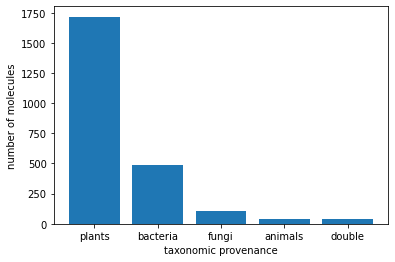

In [199]:
plt.bar(cnt.keys(),cnt.values())
plt.xlabel('taxonomic provenance')
plt.ylabel('number of molecules')

**Venn-Diagram**

In [200]:
taxonomy_Single = [list(tax) for tax in df_NP.taxonomy if 'double' not in tax]

In [201]:
taxonomy_All = taxonomy_Single + taxonomy_Double

In [202]:
plants = set()
bacteria = set()
animals = set()
fungi = set()

In [203]:
for tax_list in taxonomy_All:
    if "plants" in tax_list:
        for tax in tax_list:
            plants.add(tax.index)
    if "bacteria" in tax_list:
        for tax in tax_list:
            bacteria.add(tax.index)
    if "animals" in tax_list:
        for tax in tax_list:
            animals.add(tax.index)
    if "fungi" in tax_list:
        for tax in tax_list:
            fungi.add(tax.index)

/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/venn/_backwards_compatibility.py:16: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "`get_labels()` is retained for backwards compatibility; " +
/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


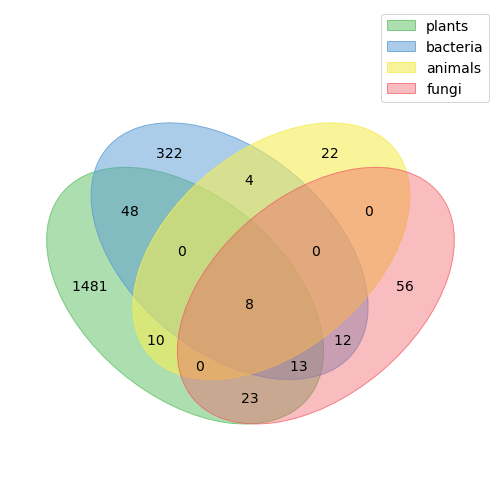

In [204]:
labels = venn.get_labels([plants,bacteria,animals,fungi])
fig, ax = venn.venn4(labels,names=['plants','bacteria','animals','fungi'])

**seperate aglycons with at least two different entries in taxonomy**


In [205]:
index_Unique_Tax = [ind for ind, tax_list in enumerate(df_NP.taxonomy) if len(tax_list) == 1]

In [206]:
df_Without_Double = df_NP.iloc[index_Unique_Tax[:]]

In [207]:
#df_Without_Double

**check for 'double' or 'triple' entries in taxonomy**

In [208]:
index_double_or_triple = [ind for ind, tax_list in enumerate(df_Without_Double.taxonomy) if 'double' not in tax_list or 'triple' not in tax_list]

In [209]:
df_Without_Double_or_Triple = df_Without_Double.iloc[index_double_or_triple[:]]

In [210]:
#df_Without_Double_or_Triple

**Fingerprints**

In [211]:
mol_From_Smiles = []
index_Mol_Explicit_Valence = []
index_Mol_Implicit_Valence = []
index = 0
for smiles in df_Without_Double_or_Triple.deglycosilated_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol == None:
        index_Mol_Explicit_Valence.append(index)
    else:
        mol_From_Smiles.append(mol)
        index_Mol_Implicit_Valence.append(index)
    index += 1    

RDKit ERROR: [15:49:07] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [15:49:07] Explicit valence for atom # 12 C, 5, is greater than permitted
RDKit ERROR: [15:49:07] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [15:49:07] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [15:49:07] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [15:49:07] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [15:49:07] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [15:49:08] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [15:49:08] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [15:49:08] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [15:49:08] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [15:49:08] Explicit valence for at

In [212]:
#print(index_Mol_Explicit_Valence)

In [213]:
df_Without_Explicit_Valence = df_Without_Double_or_Triple.iloc[index_Mol_Implicit_Valence[:]]

In [214]:
df_Without_Explicit_Valence = df_Without_Explicit_Valence.reset_index()

In [215]:
#df_Without_Explicit_Valence

In [216]:
fps = [AllChem.GetMorganFingerprint(mol,2,useFeatures=True) for mol in mol_From_Smiles]

create combinations of deglycosilated_smiles for indexing

In [217]:
aglycon_formula_for_indexing = list(df_Without_Explicit_Valence.deglycosilated_smiles)

In [218]:
aglycon_formulas = [aglycon_pair for aglycon_pair in itertools.combinations(aglycon_formula_for_indexing, 2)]

In [219]:
print(len(aglycon_formulas))

221982985


**Tanimoto Index between two different aglycons**

In [220]:
aglycon_pairs = itertools.combinations(fps, 2)

In [221]:
aglycon1_095 = []
aglycon2_095 = []
tanimoto_095 = []
aglycon1_090 = []
aglycon2_090 = []
tanimoto_090 = []
aglycon1_080 = []
aglycon2_080 = []
tanimoto_080 = []
counter = 0
for pair in aglycon_pairs:
    fingerprint = DataStructs.TanimotoSimilarity(pair[0],pair[1])
    if fingerprint >= 0.95:
        aglycon1_095.append(aglycon_formulas[counter][0])
        aglycon2_095.append(aglycon_formulas[counter][1])
        tanimoto_095.append(fingerprint)
        aglycon1_090.append(aglycon_formulas[counter][0])
        aglycon2_090.append(aglycon_formulas[counter][1])
        tanimoto_090.append(fingerprint)
        aglycon1_080.append(aglycon_formulas[counter][0])
        aglycon2_080.append(aglycon_formulas[counter][1])
        tanimoto_080.append(fingerprint)
    elif fingerprint >= 0.9:
        aglycon1_090.append(aglycon_formulas[counter][0])
        aglycon2_090.append(aglycon_formulas[counter][1])
        tanimoto_090.append(fingerprint)
        aglycon1_080.append(aglycon_formulas[counter][0])
        aglycon2_080.append(aglycon_formulas[counter][1])
        tanimoto_080.append(fingerprint)
    elif fingerprint >= 0.8:
        aglycon1_080.append(aglycon_formulas[counter][0])
        aglycon2_080.append(aglycon_formulas[counter][1])
        tanimoto_080.append(fingerprint)
    counter += 1

In [222]:
print(counter)

221982985


In [223]:
df_comparison_095 = pd.DataFrame({
    "aglycon1": aglycon1_095,
    "aglycon2": aglycon2_095,
    "tanimoto_index": tanimoto_095
})

In [224]:
df_comparison_095

,aglycon1,aglycon2,tanimoto_index
0,O=C(O)C=1C(OC)=CC=C(Br)C1C,O=C(O)C=1C(OC)=CC=C(Cl)C1C,1.000000
1,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(OC(=O)C(C)C)C(OC(C)C2C)OC3C(OC(COC(=O...,0.970760
2,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(OC(=O)CC(C)C)C(OC(C)C2C)OC3C(OC(COC(=...,0.965318
3,O=C(OC)NC1C(OC(OC2C(=CC3C=C(C)C(C)CC43OC(=O)C(...,O=C(OC)NC1C(OC(OC2C(=CC3C=C(CO)C(C)CC43OC(=O)C...,0.954248
4,O=C(OC)NC1C(OC(OC2C(=CC3C=C(C)C(C)CC43OC(=O)C(...,O=CC1=CC2C=C(C)C(OC3OC(C)C(NC(=O)OC)C([N+](=O)...,0.954248
...,...,...,...
3355,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.980892
3356,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCC)COP(=O)(O)OC1...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,1.000000
3357,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCC)COP(=O)(O)OC1...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500
3358,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500


In [225]:
df_comparison_090 = pd.DataFrame({
    "aglycon1": aglycon1_090,
    "aglycon2": aglycon2_090,
    "tanimoto_index": tanimoto_090
})

In [226]:
df_comparison_090

,aglycon1,aglycon2,tanimoto_index
0,O=C1OC(CC)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,O=C1OC(C)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,0.932432
1,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)([O-])OC1...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.944954
2,O=C(O)C=1C(OC)=CC=C(Br)C1C,O=C(O)C=1C(OC)=CC=C(Cl)C1C,1.000000
3,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(OC(=O)C(C)C)C(OC(C)C2C)OC3C(OC(COC(=O...,0.970760
4,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(O)C(OC(OC3C(OC(COC(=O)C(C)CC)C(O)C3O)...,0.910112
...,...,...,...
17009,O=S(=O)(O)ON=C(S)CCCCCCCCSC,O=S(=O)(O)ON=C(S)CCCCCCCCCSC,0.942308
17010,O=C(OC1CC(C)CNC21OC3CC4C5CCC6CC(O)CCC6(C)C5CCC...,O=C(OC1C(O)C(C)CNC21OC3CC4C5CCC6CC(O)CCC6(C)C5...,0.900990
17011,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,O=C(OCC(OC(=O)CCCCCCCCCCCCCC)COP(=O)(O)OC1C(O)...,0.925000
17012,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,O=C(OCC(OC(=O)CCCCCCCCC(C)CCCCCCCC)COP(=O)(O)O...,0.938650


In [227]:
df_comparison_080 = pd.DataFrame({
    "aglycon1": aglycon1_080,
    "aglycon2": aglycon2_080,
    "tanimoto_index": tanimoto_080
})

In [228]:
df_comparison_080

,aglycon1,aglycon2,tanimoto_index
0,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(C)CCCC12C,0.890625
1,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,OCC=C(C)CCC1C(O)(C)CC(O)C2C(C)(CO)CCCC12C,0.826087
2,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,OCCC(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,0.823529
3,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,OCC=C(C)CCC1C(=C)CCC2C(C)(CO)CCCC12C,0.848485
4,OCC=C(C)CCC1C(=C)CC(O)C2C(C)(CO)CCCC12C,OCC=C(C)CCC1C(=C)CCC2C(C)(CO)CC(O)CC12C,0.823529
...,...,...,...
102053,O=C(NC(CO)C(O)CCCCCC=CCCCCCCCC)C(O)CCCCCCCCCCCCCC,O=C(NC(CO)C(O)C=CCCCC=C(C)CCCCCCCC)C(O)C=CCCCC...,0.811024
102054,O=C([O-])C12CCC(C(=O)OC)(C)CC2C3=CCC4C5(C)CCC(...,O=C(OC)C1(C)CCC2(C)CCC3(C(=CCC4C5(C)CCC(O)C(C)...,0.822430
102055,O=C1OC2CC1(C)CC3C4=CCC5C6(C)CCC(O)C(C)(C)C6CCC...,O=C(OC)C1(C)CCC2(C)CCC3(C(=CCC4C5(C)CCC(O)C(C)...,0.813725
102056,O=C(OC1=CC=C2C(=O)C3=C(O)C(=C(O)C=C3C(=O)C2=C1...,O=C(OC1=CC=C2C(=O)C3=C(O)C(=C(O)C=C3C(=O)C2=C1...,0.897436


**merging dataframe and taxonomies**

In [229]:
df_aglycon_taxes_1 = pd.DataFrame({
    "aglycon1": df_Without_Double.deglycosilated_smiles,
    "taxonomy1": df_Without_Double.taxonomy,
})

In [230]:
df_aglycon_taxes_2 = pd.DataFrame({
    "aglycon2": df_Without_Double.deglycosilated_smiles,
    "taxonomy2": df_Without_Double.taxonomy,
})

*df_comparison_095*

In [231]:
df_comparison_095 = pd.merge(df_comparison_095, df_aglycon_taxes_1, how="left", on="aglycon1")

In [232]:
df_comparison_095 = pd.merge(df_comparison_095, df_aglycon_taxes_2, how="left", on="aglycon2")

In [233]:
df_comparison_095

,aglycon1,aglycon2,tanimoto_index,taxonomy1,taxonomy2
0,O=C(O)C=1C(OC)=CC=C(Br)C1C,O=C(O)C=1C(OC)=CC=C(Cl)C1C,1.000000,{plants},{bacteria}
1,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(OC(=O)C(C)C)C(OC(C)C2C)OC3C(OC(COC(=O...,0.970760,{plants},{plants}
2,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(OC(=O)CC(C)C)C(OC(C)C2C)OC3C(OC(COC(=...,0.965318,{plants},{plants}
3,O=C(OC)NC1C(OC(OC2C(=CC3C=C(C)C(C)CC43OC(=O)C(...,O=C(OC)NC1C(OC(OC2C(=CC3C=C(CO)C(C)CC43OC(=O)C...,0.954248,{no},{no}
4,O=C(OC)NC1C(OC(OC2C(=CC3C=C(C)C(C)CC43OC(=O)C(...,O=CC1=CC2C=C(C)C(OC3OC(C)C(NC(=O)OC)C([N+](=O)...,0.954248,{no},{no}
...,...,...,...,...,...
3355,O=C(OCC(OC(=O)CCCCCCCCCCCCC)COP(=O)(O)OC1C(O)C...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.980892,{no},{no}
3356,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCC)COP(=O)(O)OC1...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,1.000000,{no},{no}
3357,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCCC)COP(=O)(O)OC1...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500,{no},{no}
3358,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.962500,{no},{no}


*change tax-sets to values from 1 to 5*

In [234]:
tax1_to_value_095 = df_comparison_095.taxonomy1.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [235]:
tax2_to_value_095 = df_comparison_095.taxonomy2.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [236]:
df_comparison_095["tax1_as_value"] = tax1_to_value_095

In [237]:
df_comparison_095["tax2_as_value"] = tax2_to_value_095

In [238]:
df_comparison_095.to_csv("fingerprint_comparison095.tsv",sep="\t")

*df_comparison_090*

In [239]:
df_comparison_090 = pd.merge(df_comparison_090, df_aglycon_taxes_1, how="left", on="aglycon1")

In [240]:
df_comparison_090 = pd.merge(df_comparison_090, df_aglycon_taxes_2, how="left", on="aglycon2")

In [241]:
df_comparison_090

,aglycon1,aglycon2,tanimoto_index,taxonomy1,taxonomy2
0,O=C1OC(CC)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,O=C1OC(C)C(CO)C2OC2C=CC(=O)C(C)CC(C)C(O)C(C=C1)C,0.932432,{no},{bacteria}
1,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)([O-])OC1...,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,0.944954,{no},{no}
2,O=C(O)C=1C(OC)=CC=C(Br)C1C,O=C(O)C=1C(OC)=CC=C(Cl)C1C,1.000000,{plants},{bacteria}
3,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(OC(=O)C(C)C)C(OC(C)C2C)OC3C(OC(COC(=O...,0.970760,{plants},{plants}
4,O=C1OC2C(OC(=O)C(C)CC)C(OC(C)C2C)OC3C(OC(COC(=...,O=C1OC2C(O)C(OC(OC3C(OC(COC(=O)C(C)CC)C(O)C3O)...,0.910112,{plants},{no}
...,...,...,...,...,...
17009,O=S(=O)(O)ON=C(S)CCCCCCCCSC,O=S(=O)(O)ON=C(S)CCCCCCCCCSC,0.942308,{no},{no}
17010,O=C(OC1CC(C)CNC21OC3CC4C5CCC6CC(O)CCC6(C)C5CCC...,O=C(OC1C(O)C(C)CNC21OC3CC4C5CCC6CC(O)CCC6(C)C5...,0.900990,{no},{no}
17011,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,O=C(OCC(OC(=O)CCCCCCCCCCCCCC)COP(=O)(O)OC1C(O)...,0.925000,{no},{no}
17012,O=C(OCC(OC(=O)CCCCCCCCCCCCCCC)COP(=O)(O)OC1C(O...,O=C(OCC(OC(=O)CCCCCCCCC(C)CCCCCCCC)COP(=O)(O)O...,0.938650,{no},{no}


*change tax-sets to values from 1 to 5*

In [242]:
tax1_to_value_090 = df_comparison_090.taxonomy1.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [243]:
tax2_to_value_090 = df_comparison_090.taxonomy2.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [244]:
df_comparison_090["tax1_as_value"] = tax1_to_value_090

In [245]:
df_comparison_090["tax2_as_value"] = tax2_to_value_090

In [246]:
df_comparison_090.to_csv("fingerprint_comparison090.tsv",sep="\t")

*df_comparison_080*

In [247]:
df_comparison_080 = pd.merge(df_comparison_080, df_aglycon_taxes_1, how="left", on="aglycon1")

In [248]:
df_comparison_080 = pd.merge(df_comparison_080, df_aglycon_taxes_2, how="left", on="aglycon2")

*change tax-sets to values from 1 to 5*

In [249]:
tax1_to_value_080 = df_comparison_080.taxonomy1.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [250]:
tax2_to_value_080 = df_comparison_080.taxonomy2.replace([{"no"},{"plants"},{"bacteria"},{"animals"},{"fungi"}],[1,2,3,4,5])

In [251]:
df_comparison_080["tax1_as_value"] = tax1_to_value_080

In [252]:
df_comparison_080["tax2_as_value"] = tax2_to_value_080

In [253]:
df_comparison_080.to_csv("fingerprint_comparison080.tsv",sep="\t")